In [28]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report
from sklearn.model_selection import train_test_split

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

%matplotlib inline

In [3]:
data = pd.read_csv('./Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
address2country = pd.read_csv('./IpAddress_to_Country.csv')
address2country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [26]:
# Merge the two datasets and print the first 5 rows

merged_data = pd.merge_asof(data.sort_values('ip_address'), address2country.sort_values('lower_bound_ip_address'), left_on='ip_address', right_on='lower_bound_ip_address', direction='forward', allow_exact_matches=True)
merged_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,original_order,lower_bound_ip_address,upper_bound_ip_address,country
0,62421,2015-02-16 00:17:05,2015-03-08 10:00:39,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,52093.496895,0,110447,16777216.0,16777471.0,Australia
1,173212,2015-03-08 04:03:22,2015-03-20 17:23:45,33,YFGYOALADBHLT,Ads,IE,F,30,93447.138961,0,2589,16777216.0,16777471.0,Australia
2,242286,2015-05-17 16:45:54,2015-05-26 08:54:34,33,QZNVQTUITFTHH,Direct,FireFox,F,32,105818.501505,0,16752,16777216.0,16777471.0,Australia
3,370003,2015-03-03 19:58:39,2015-05-28 21:09:13,33,PIBUQMBIELMMG,Ads,IE,M,40,117566.664867,0,51261,16777216.0,16777471.0,Australia
4,119824,2015-03-20 00:31:27,2015-04-05 07:31:46,55,WFIIFCPIOGMHT,Ads,Safari,M,38,131423.789042,0,17,16777216.0,16777471.0,Australia


In [16]:
# Get the time difference between purchase time and signup time
merged_data['time_diff'] = (merged_data['purchase_time'] - merged_data['signup_time']).dt.total_seconds() / 3600
merged_data['time_diff']

0          489.726111
1          301.339722
2          208.144444
3         2065.176111
4          391.005278
             ...     
151107    2560.360556
151108     477.590278
151109    1569.222222
151110    1818.114722
151111    1511.090833
Name: time_diff, Length: 151112, dtype: float64

In [15]:
# Check user number for unique devices
merged_data['device_num'] = merged_data.groupby('device_id')['user_id'].transform('nunique')
merged_data['device_num']

0         1
1         1
2         1
3         1
4         1
         ..
151107    1
151108    1
151109    1
151110    1
151111    1
Name: device_num, Length: 151112, dtype: int64

In [17]:
# Check user number for unique ip_address
merged_data['ip_num'] = merged_data.groupby('ip_address')['user_id'].transform('nunique')
merged_data['ip_num']

0         1
1         1
2         1
3         1
4         1
         ..
151107    1
151108    1
151109    1
151110    1
151111    1
Name: ip_num, Length: 151112, dtype: int64

In [19]:
# Signup day and week
merged_data['signup_day'] = merged_data['signup_time'].dt.dayofweek  
merged_data['signup_week'] = merged_data['signup_time'].dt.isocalendar().week
merged_data[['signup_day','signup_week']]

,signup_day,signup_week
0,0,8
1,6,10
2,6,20
3,1,10
4,4,12
...,...,...
151107,3,16
151108,5,32
151109,2,8
151110,5,33


In [21]:
# Purchase day and week
merged_data['purchase_day'] = merged_data['purchase_time'].dt.dayofweek 
merged_data['purchase_week'] = merged_data['purchase_time'].dt.isocalendar().week
merged_data[['purchase_day','purchase_week']]

,purchase_day,purchase_week
0,6,10
1,4,12
2,1,22
3,3,22
4,6,14
...,...,...
151107,4,31
151108,4,35
151109,5,17
151110,4,44


In [25]:
# Define features and target to be used
final_data = merged_data.drop(columns=['signup_time', 'purchase_time', 'device_id', 'ip_address', 'user_id'])
cols_order = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 'browser', 'sex', 'age', 'country', 'time_diff', 'device_num', 'ip_num', 'class']
final_data = final_data[cols_order]
final_data

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,country,time_diff,device_num,ip_num,class
0,0,8,6,10,46,Direct,Safari,M,36,Australia,489.726111,1,1,0
1,6,10,4,12,33,Ads,IE,F,30,Australia,301.339722,1,1,0
2,6,20,1,22,33,Direct,FireFox,F,32,Australia,208.144444,1,1,0
3,1,10,3,22,33,Ads,IE,M,40,Australia,2065.176111,1,1,0
4,4,12,6,14,55,Ads,Safari,M,38,Australia,391.005278,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,3,16,4,31,39,Direct,FireFox,F,36,NaN,2560.360556,1,1,0
151108,5,32,4,35,62,SEO,IE,M,22,NaN,477.590278,1,1,0
151109,2,8,5,17,17,SEO,FireFox,M,19,NaN,1569.222222,1,1,0
151110,5,33,4,44,9,Ads,IE,F,35,NaN,1818.114722,1,1,0


In [29]:
# Define features and target
features = final_data.drop(columns=['class'])
target = final_data['class']

# Split into 70% training and 30% test dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [34]:
# Build random forest model
drf = H2ORandomForestEstimator(ntrees=50, max_depth=20, nfolds=10)
drf.train(x=predictors, y=response, training_frame=train)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: DRF_model_python_1693407228885_1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    50                 50                          2.28416e+06            20           20           20            1849          3773          2920.18

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.04025176733230329
RMSE: 0.20062843101690073
MAE: 0.07883966783400613
RMSLE: 0.1418585616599454
Mean Residual Deviance: 0.04025176733230329

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.039570265243739584
RMSE: 0.19892276200510484
MAE: 0.0791073664442246
RMSLE: 0.1400012959176421
Mean Residual Deviance: 0.039570265243739584

Cross-Validation Metrics Summary: 
                        mean       sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  -----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.0791085  0.00065874   0.0801678     0.0781262     0.0787793     0.0794418     0.0785759     0.0789444     0.078506      0.0795045     0.0790558     0.0799836
mean_residual_deviance  0.0395716  0.000850112  0.040833      0.0386966     0.0388421     0.0394238     0.0387237     0.039582      0.0386601     0.0407893     0.0399454     0.0402204
mse                     0.0395716  0.000850112  0.040833      0.0386966     0.0388421     0.0394238     0.0387237     0.039582      0.0386601     0.0407893     0.0399454     0.0402204
r2                      0.530461   0.0106495    0.520458      0.527948      0.528608      0.517781      0.530551      0.520815      0.54879       0.534825      0.547549      0.527288
residual_deviance       0.0395716  0.000850112  0.040833      0.0386966     0.0388421     0.0394238     0.0387237     0.039582      0.0386601     0.0407893     0.0399454     0.0402204
rmse                    0.198916   0.0021334    0.202072      0.196714      0.197084      0.198554      0.196783      0.198952      0.196622      0.201964      0.199863      0.20055
rmsle                   0.139997   0.00134859   0.142065      0.138923      0.138986      0.139468      0.138536      0.140386      0.138327      0.141773      0.140399      0.141111

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------------  -----------------  -------------------  -------------------  --------------------
     2023-08-30 15:58:28  1 min  7.059 sec  0.0                nan                  nan                  nan
     2023-08-30 15:58:28  1 min  7.361 sec  1.0                0.24815071363035024  0.07869564727236304  0.061578776675252085
     2023-08-30 15:58:28  1 min  7.535 sec  2.0                0.24402839442347082  0.07905110599620244  0.05954985728489705
     2023-08-30 15:58:29  1 min  7.693 sec  3.0                0.2380099492961402   0.07841947566966685  0.05664873596395123
     2023-08-30 15:58:29  1 min  7.797 sec  4.0                0.23433213098393102  0.07886538397567615  0.0549115476114702
     2023-08-30 15:58:29  1 min  7.911 sec  5.0                0.2308240730737126   0.07929447649762168  0.053279752710338614
     2023-08-30 15:58:29  1 min  8.049 sec  6.0                0.22782818206694444  0.07904111979150198  0.05190568054392878
     2023-08-30 15:58:29  1 min  8.193 sec  7.0                0.22349337243287737  0.07882512575306198  0.049949287521420825
     2023-08-30 15:58:29 

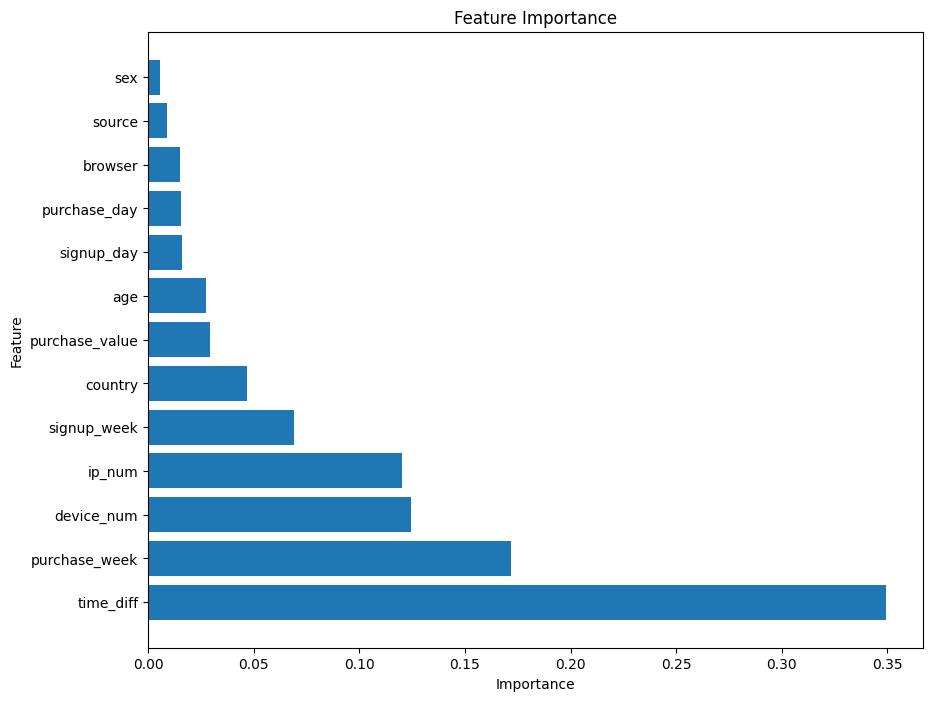

In [35]:
# Feature importance
feature_importances = drf.varimp(use_pandas=True)
feature_importances = feature_importances.sort_values(by='percentage', ascending=False)
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['variable'], feature_importances['percentage'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.savefig("Importances.png")

In [37]:
# Classification report
y_test_pred = drf.predict(test).as_data_frame()
y_test_true = test['class'].as_data_frame()
y_test_pred['predict_class'] = y_test_pred['predict'].apply(lambda x: 1 if x > 0.5 else 0)
report = classification_report(y_test_true['class'], y_test_pred['predict_class'])
report

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


'              precision    recall  f1-score   support\n\n           0       0.95      1.00      0.98     41017\n           1       0.98      0.54      0.70      4317\n\n    accuracy                           0.96     45334\n   macro avg       0.97      0.77      0.84     45334\nweighted avg       0.96      0.96      0.95     45334\n'

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


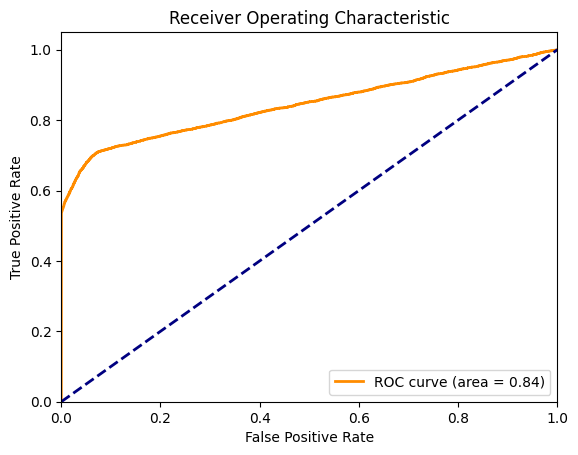

In [38]:
# Plot ROC curve
pred = drf.predict(test)
y_test_probs = pred.as_data_frame()['predict'].values
y_test_probs = drf.predict(test).as_data_frame()['predict']
fpr, tpr, _ = roc_curve(y_test_true['class'], y_test_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("ROC_Fraud.png")